In [1]:
!pip uninstall tensorflow
!pip install tensorflow==2.7.0

Found existing installation: tensorflow 2.8.2+zzzcolab20220527125636
Uninstalling tensorflow-2.8.2+zzzcolab20220527125636:
  Would remove:
    /usr/local/bin/estimator_ckpt_converter
    /usr/local/bin/import_pb_to_tensorboard
    /usr/local/bin/saved_model_cli
    /usr/local/bin/tensorboard
    /usr/local/bin/tf_upgrade_v2
    /usr/local/bin/tflite_convert
    /usr/local/bin/toco
    /usr/local/bin/toco_from_protos
    /usr/local/lib/python3.7/dist-packages/tensorflow-2.8.2+zzzcolab20220527125636.dist-info/*
    /usr/local/lib/python3.7/dist-packages/tensorflow/*
Proceed (y/n)? y
  Successfully uninstalled tensorflow-2.8.2+zzzcolab20220527125636
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     | 665.5 MB 115.7 MB/s
     |████████████████████████████████| 463 kB 27.4 MB/s 
     |████████████████████████████████| 1.3 MB 38.9 MB/s 
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.8.

## What we're going to cover

* Downloading a text dataset
* Visualizing text data
* Converting text into numbers using tokenization
* Turning our tokenized text into an embedding
* Modelling a text dataset
* Starting with a baseline (TF-IDF)
* Building several deep learning text models
* Dense, LSTM, GRU, Conv1D, Transfer learning
* Comparing the performance of each our models
* Combining our models into an ensemble
* Saving and loading a trained model
* Find the most wrong predictions

## Get Helper Functions

In [2]:
# Download helper functions script
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2022-06-29 04:45:04--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2022-06-29 04:45:05 (67.4 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [3]:
# Import series of helper functions for the notebook
from helper_functions import unzip_data, create_tensorboard_callback, plot_loss_curves, compare_historys

## Download a text dataset

Let's start by download a text dataset. We'll be using the Real or Not? datset from Kaggle which contains text-based Tweets about natural disasters.

The Real Tweets are actually about diasters, for example:

Jetstar and Virgin forced to cancel Bali flights again because of ash from Mount Raung volcano
The Not Real Tweets are Tweets not about diasters (they can be on anything), for example:

'Education is the most powerful weapon which you can use to change the world.' Nelson #Mandela #quote
For convenience, the dataset has been downloaded from Kaggle (doing this requires a Kaggle account) and uploaded as a downloadable zip file.

>🔑 Note: The original downloaded data has not been altered to how you would download it from Kaggle.


In [4]:
# Download data (same as from Kaggle)
!wget "https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip"

# Unzip data
unzip_data("nlp_getting_started.zip")

--2022-06-29 04:45:09--  https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.81.208, 172.217.1.208, 142.250.73.208, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.81.208|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 607343 (593K) [application/zip]
Saving to: ‘nlp_getting_started.zip’

nlp_getting_started 100%[===================>] 593.11K  --.-KB/s    in 0.005s  

2022-06-29 04:45:09 (114 MB/s) - ‘nlp_getting_started.zip’ saved [607343/607343]



Unzipping `nlp_getting_started.zip` gives the following 3 .csv files:

* `sample_submission.csv` - an example of the file you'd submit to the Kaggle competition of your model's predictions.
* `train.csv` - training samples of real and not real diaster Tweets.
* `test.csv` - testing samples of real and not real diaster Tweets.

## Visualizing a text dataset




Right now, our text data samples are in the form of .csv files. For an easy way to make them visual, let's turn them into pandas DataFrame's.

In [5]:
# Turn .csv files into pandas DataFrame's
import pandas as pd
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [6]:
# Shuffle training dataframe
train_df_shuffled = train_df.sample(frac=1, random_state=42) # shuffle with random_state=42 for reproducibility
train_df_shuffled.head()

,id,keyword,location,text,target
2644,3796,destruction,NaN,So you have a new weapon that can cause un-ima...,1
2227,3185,deluge,NaN,The f$&amp;@ing things I do for #GISHWHES Just...,0
5448,7769,police,UK,DT @georgegalloway: RT @Galloway4Mayor: ÛÏThe...,1
132,191,aftershock,NaN,Aftershock back to school kick off was great. ...,0
6845,9810,trauma,"Montgomery County, MD",in response to trauma Children of Addicts deve...,0


Notice how the training data has a "target" column.

We're going to be writing code to find patterns (e.g. different combinations of words) in the "text" column of the training dataset to predict the value of the "target" column.

The test dataset doesn't have a "target" column.

In [7]:
# The test data doesn't have a target (that's what we'd try to predict)
test_df.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [8]:
# How many examples of each class?
train_df.target.value_counts()

0    4342
1    3271
Name: target, dtype: int64


Since we have two target values, we're dealing with a binary classification problem.

It's fairly balanced too, about 60% negative class (target = 0) and 40% positive class (target = 1).

Where,

>`1` = a real disaster Tweet

>`0` = not a real disaster Tweet

In [9]:

# How many samples total?
print(f"Total training samples: {len(train_df)}")
print(f"Total test samples: {len(test_df)}")
print(f"Total samples: {len(train_df) + len(test_df)}")

Total training samples: 7613
Total test samples: 3263
Total samples: 10876


Abundance of test data, usually 80/20 split is fine

In [10]:

# Let's visualize some random training examples
import random
random_index = random.randint(0, len(train_df)-5) # create random indexes not higher than the total number of samples
for row in train_df_shuffled[["text", "target"]][random_index:random_index+5].itertuples():
  _, text, target = row
  print(f"Target: {target}", "(real disaster)" if target > 0 else "(not real disaster)")
  print(f"Text:\n{text}\n")
  print("---\n")

Target: 0 (not real disaster)
Text:
#picthis http://t.co/br7gmMh5Ek ÛÓ And IÛªm off! Thank you so much #Toronto. It has been such a whirlwind of amazingness. So glad I finallÛ_

---

Target: 0 (not real disaster)
Text:
@thetimepast @saalon I have childhood trauma more resolved than theirs. Actual trauma. Fricken babies.

---

Target: 0 (not real disaster)
Text:
Daily Reflections
August 6
DRIVEN
Driven by a hundred forms of fear self-delusion self-seeking and self-pity... http://t.co/DXfqOu4kT2

---

Target: 0 (not real disaster)
Text:
I liked a @YouTube video from @dannyonpc http://t.co/PyVRPrNhOP Battlefield Hardline - 11 NEW WEAPONS - New map - Throwingknifes!

---

Target: 1 (real disaster)
Text:
Dear @POTUS In the name of humanityI apologized to #Hiroshima Survivors.R u ready to do so?#Japan #nuclearweapons http://t.co/TWykzN4rlC

---



## Split data into training and validation sets


Since the test set has no labels and we need a way to evalaute our trained models, we'll split off some of the training data and create a validation set.

When our model trains (tries patterns in the Tweet samples), it'll only see data from the training set and we can see how it performs on unseen data using the validation set.

We'll convert our splits from pandas Series datatypes to lists of strings (for the text) and lists of ints (for the labels) for ease of use later.

In [11]:
from sklearn.model_selection import train_test_split

# Use train_test_split to split training data into training and validation sets
train_sentences, val_sentences, train_labels, val_labels = train_test_split(train_df_shuffled["text"].to_numpy(),
                                                                            train_df_shuffled["target"].to_numpy(),
                                                                            test_size=0.1, # dedicate 10% of samples to validation set
                                                                            random_state=42) # random state for reproducibility

In [12]:

# Check the lengths
len(train_sentences), len(train_labels), len(val_sentences), len(val_labels)

(6851, 6851, 762, 762)

In [13]:
# View the first 10 training sentences and their labels
train_sentences[:10], train_labels[:10]

(array(['@mogacola @zamtriossu i screamed after hitting tweet',
        'Imagine getting flattened by Kurt Zouma',
        '@Gurmeetramrahim #MSGDoing111WelfareWorks Green S welfare force ke appx 65000 members har time disaster victim ki help ke liye tyar hai....',
        "@shakjn @C7 @Magnums im shaking in fear he's gonna hack the planet",
        'Somehow find you and I collide http://t.co/Ee8RpOahPk',
        '@EvaHanderek @MarleyKnysh great times until the bus driver held us hostage in the mall parking lot lmfao',
        'destroy the free fandom honestly',
        'Weapons stolen from National Guard Armory in New Albany still missing #Gunsense http://t.co/lKNU8902JE',
        '@wfaaweather Pete when will the heat wave pass? Is it really going to be mid month? Frisco Boy Scouts have a canoe trip in Okla.',
        'Patient-reported outcomes in long-term survivors of metastatic colorectal cancer - British Journal of Surgery http://t.co/5Yl4DC1Tqt'],
       dtype=object), array([0, 

## Converting text into numbers



In NLP, there are two main concepts for turning text into numbers:

**Tokenization** - A straight mapping from word or character or sub-word to a numerical value. There are three main levels of tokenization:
1. Using **word-level** tokenization with the sentence "I love TensorFlow" might result in "I" being 0, "love" being 1 and "TensorFlow" being 2. In this case, every word in a sequence considered a single token.
2. **Character-level tokenization**, such as converting the letters A-Z to values 1-26. In this case, every character in a sequence considered a single token.
3.**Sub-word tokenization** is in between word-level and character-level tokenization. It involves breaking invidual words into smaller parts and then converting those smaller parts into numbers. For example, "my favourite food is pineapple pizza" might become "my, fav, avour, rite, fo, oo, od, is, pin, ine, app, le, piz, za". After doing this, these sub-words would then be mapped to a numerical value. In this case, every word could be considered multiple tokens.

**Embeddings** - An embedding is a representation of natural language which can be learned. Representation comes in the form of a feature vector. For example, the word "dance" could be represented by the 5-dimensional vector [-0.8547, 0.4559, -0.3332, 0.9877, 0.1112]. It's important to note here, the size of the feature vector is tuneable. There are two ways to use embeddings:
1. **Create your own embedding**- Once your text has been turned into numbers (required for an embedding), you can put them through an embedding layer (such as tf.keras.layers.Embedding) and an embedding representation will be learned during model training.
2. Reuse a pre-learned embedding - Many pre-trained embeddings exist online. These pre-trained embeddings have often been learned on large corpuses of text (such as all of Wikipedia) and thus have a good underlying representation of natural language. You can use a pre-trained embedding to initialize your model and fine-tune it to your own specific task.

## Text vectorization (tokenization)

The `TextVectorization` layer takes the following parameters:

*` max_tokens` - The maximum number of words in your vocabulary (e.g. 20000 or the number of unique words in your text), includes a value for OOV (out of vocabulary) tokens.
* `standardize` - Method for standardizing text. Default is "lower_and_strip_punctuation" which lowers text and removes all punctuation marks.
* `split` - How to split text, default is "whitespace" which splits on spaces.
* `ngrams` - How many words to contain per token split, for example, ngrams=2 splits tokens into continuous sequences of 2.
*` output_mode` - How to output tokens, can be "int" (integer mapping), "binary" (one-hot encoding), "count" or "tf-idf". See documentation for more.
*` output_sequence_length` - Length of tokenized sequence to output. For example, if output_sequence_length=150, all tokenized sequences will be 150 tokens long.
* `pad_to_max_tokens` - Defaults to False, if True, the output feature axis will be padded to max_tokens even if the number of unique tokens in the vocabulary is less than max_tokens. Only valid in certain modes, see docs for more.

In [14]:
import tensorflow as tf
from tensorflow.keras.layers import TextVectorization
# Note: in TensorFlow 2.6+, you no longer need "layers.experimental.preprocessing"
# you can use: "tf.keras.layers.TextVectorization", see https://github.com/tensorflow/tensorflow/releases/tag/v2.6.0 for more

# Use the default TextVectorization variables
text_vectorizer = TextVectorization(max_tokens=None, # how many words in the vocabulary (all of the different words in your text)
                                    standardize="lower_and_strip_punctuation", # how to process text
                                    split="whitespace", # how to split tokens
                                    ngrams=None, # create groups of n-words?
                                    output_mode="int", # how to map tokens to numbers
                                    output_sequence_length=None) # how long should the output sequence of tokens be?
                                    # pad_to_max_tokens=True) # Not valid if using max_tokens=None

We've initialized a `TextVectorization` object with the default settings but let's customize it a little bit for our own use case.

In particular, let's set values for `max_token`s and `output_sequence_length.`

For max_tokens (the number of words in the vocabulary), multiples of 10,000 (10,000, 20,000, 30,000) or the exact number of unique words in your text (e.g. 32,179) are common values.

For our use case, we'll use 10,000.

And for the output_sequence_length we'll use the average number of tokens per Tweet in the training set. But first, we'll need to find it.

In [15]:
# Find average number of tokens (words) in training Tweets
round(sum([len(i.split()) for i in train_sentences])/len(train_sentences))

15

In [16]:
# Setup text vectorization with custom variables
max_vocab_length = 10000 # max number of words to have in our vocabulary
max_length = 15 # max length our sequences will be (e.g. how many words from a Tweet does our model see?)

text_vectorizer = TextVectorization(max_tokens=max_vocab_length,
                                    output_mode="int",
                                    output_sequence_length=max_length)

In [17]:
# Fit the text vectorizer to the training text
text_vectorizer.adapt(train_sentences)

In [18]:
# Create sample sentence and tokenize it
sample_sentence = "There's a flood in my street!"
text_vectorizer([sample_sentence])

<tf.Tensor: shape=(1, 15), dtype=int64, numpy=
array([[264,   3, 232,   4,  13, 698,   0,   0,   0,   0,   0,   0,   0,
          0,   0]])>

How about we try our text_vectorizer on a few random sentences?

In [19]:
# Choose a random sentence from the training dataset and tokenize it
random_sentence = random.choice(train_sentences)
print(f"Original text:\n{random_sentence}\
      \n\nVectorized version:")
text_vectorizer([random_sentence])

Original text:
Former Freedom Surf/Spa Razed to Make Way for New Homes http://t.co/EX6JzQJ3NI      

Vectorized version:


<tf.Tensor: shape=(1, 15), dtype=int64, numpy=
array([[ 952, 2454, 7903,  477,    5,  144,  147,   10,   50,  195,    1,
           0,    0,    0,    0]])>

In [20]:
## Get the unique words in the vocabulary
words_in_vocab = text_vectorizer.get_vocabulary()
top_5_words = words_in_vocab[:5] # most common tokens (notice the [UNK] token for "unknown" words)
bottom_5_words = words_in_vocab[-5:] # least common tokens
print(f"Number of words in vocab: {len(words_in_vocab)}")
print(f"Top 5 most common words: {top_5_words}") 
print(f"Bottom 5 least common words: {bottom_5_words}")

Number of words in vocab: 10000
Top 5 most common words: ['', '[UNK]', 'the', 'a', 'in']
Bottom 5 least common words: ['pages', 'paeds', 'pads', 'padres', 'paddytomlinson1']


## Creating an Embedding Using the Embedding Layer

Creating an Embedding using an Embedding Layer
We've got a way to map our text to numbers. How about we go a step further and turn those numbers into an embedding?

The powerful thing about an embedding is it can be learned during training. This means rather than just being static (e.g. 1 = I, 2 = love, 3 = TensorFlow), a word's numeric representation can be improved as a model goes through data samples.

We can see what an embedding of a word looks like by using the tf.keras.layers.Embedding layer.

The main parameters we're concerned about here are:

* `input_dim` - The size of the vocabulary (e.g. len(text_vectorizer.get_vocabulary()).
* `output_dim` - The size of the output embedding vector, for example, a value of 100 outputs a feature vector of size 100 for each word.
* `embeddings_initializer` - How to initialize the embeddings matrix, default is "uniform" which randomly initalizes embedding matrix with uniform distribution. This can be changed for using pre-learned embeddings.
* `input_length` - Length of sequences being passed to embedding layer.
Knowing these, let's make an embedding layer.



In [21]:
tf.random.set_seed(42)
from tensorflow.keras import layers

embedding = layers.Embedding(input_dim=max_vocab_length, # set input shape
                             output_dim=128, # set size of embedding vector
                             embeddings_initializer="uniform", # default, intialize randomly
                             input_length=max_length, # how long is each input
                             name="embedding_1") 

embedding

Excellent, notice how embedding is a TensorFlow layer? This is important because we can use it as part of a model, meaning its parameters (word representations) can be updated and improved as the model learns.

In [22]:

# Get a random sentence from training set
random_sentence = random.choice(train_sentences)
print(f"Original text:\n{random_sentence}\
      \n\nEmbedded version:")

# Embed the random sentence (turn it into numerical representation)
sample_embed = embedding(text_vectorizer([random_sentence]))
sample_embed

Original text:
WACKOS like #MicheleBachman predict the WORLD will SOON be OBLITERATED by a burning firey INFERNO but cant accept #GlobalWarming!! HELLO!!!      

Embedded version:


<tf.Tensor: shape=(1, 15, 128), dtype=float32, numpy=
array([[[-0.00640418,  0.01682251,  0.00195462, ...,  0.04359378,
          0.04193902,  0.0012416 ],
        [-0.03071752,  0.04972876, -0.01677845, ..., -0.03565687,
          0.0019665 , -0.04666593],
        [ 0.03439753, -0.02137036, -0.04002481, ..., -0.01126385,
         -0.02075452, -0.02154907],
        ...,
        [-0.02280595,  0.04378835,  0.04515358, ..., -0.02526791,
          0.00563388, -0.01470927],
        [ 0.02825913, -0.03693267, -0.04402525, ..., -0.02885563,
         -0.03234972, -0.02033558],
        [ 0.01112027, -0.02055171,  0.0250339 , ...,  0.0140762 ,
          0.00621351, -0.01795131]]], dtype=float32)>

In [23]:
# Check out a single token's embedding
sample_embed[0][0]

<tf.Tensor: shape=(128,), dtype=float32, numpy=
array([-0.00640418,  0.01682251,  0.00195462, -0.03352938,  0.04405266,
       -0.03851814,  0.00149175,  0.02461456, -0.00086755,  0.0383161 ,
       -0.03941747, -0.04108413,  0.03866457,  0.04693766, -0.03705329,
        0.03713027, -0.01164728, -0.01496168,  0.04328063, -0.03559051,
       -0.03948933, -0.00122237,  0.02830635, -0.0494219 , -0.00473925,
        0.0185906 , -0.04443493,  0.00617117, -0.03494148, -0.04809414,
       -0.01621503, -0.01370454, -0.0382251 , -0.00914737, -0.00739085,
        0.03948393,  0.0489594 , -0.0283396 , -0.04380312,  0.00267646,
       -0.00154066, -0.03798597,  0.02179739,  0.00488193,  0.02941428,
        0.01133228, -0.02147579, -0.0228446 ,  0.03041137,  0.04153759,
        0.03724631, -0.02031036,  0.03627517,  0.02785117,  0.04418415,
       -0.00950921,  0.0195733 , -0.02571585, -0.03526436, -0.04323376,
       -0.02038094,  0.0232881 ,  0.00864964, -0.02877491,  0.03783163,
        0.007368

## Modelling a text dataset

Now that we've got a way to turn our text data into numbers, we can start to build machine learning models to model it.

To get plenty of practice, we're going to build a series of different models, each as its own experiment. We'll then compare the results of each model and see which one performed best.

More specifically, we'll be building the following:

* Model 0: Naive Bayes (baseline)
* Model 1: Feed-forward neural network (dense model)
* Model 2: LSTM model
* Model 3: GRU model
* Model 4: Bidirectional-LSTM model
* Model 5: 1D Convolutional Neural Network
* Model 6: TensorFlow Hub Pretrained Feature Extractor
* Model 7: Same as model 6 with 10% of training data

Model 0 is the simplest to acquire a baseline which we'll expect each other of the other deeper models to beat.



### Model 0: Getting a Baseline

In [24]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# Create tokenization and modelling pipeline
model_0 = Pipeline([
                    ("tfidf", TfidfVectorizer()), # convert words to numbers using tfidf
                    ("clf", MultinomialNB()) # model the text
])

# Fit the pipeline to the training data
model_0.fit(train_sentences, train_labels)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())])

The benefit of using a shallow model like Multinomial Naive Bayes is that training is very fast.

Let's evaluate our model and find our baseline metric.

In [25]:
# Make predictions
baseline_preds = model_0.predict(val_sentences)
baseline_preds[:20]

array([1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1])

## Creating an evaluation function for our model experiments
We could evaluate these as they are but since we're going to be evaluating several models in the same way going forward, let's create a helper function which takes an array of predictions and ground truth labels and computes the following:

* Accuracy
* Precision
* Recall
* F1-score
> 🔑 Note: Since we're dealing with a classification problem, the above metrics are the most appropriate. If we were working with a regression problem, other metrics such as MAE (mean absolute error) would be a better choice.

In [26]:
# Function to evaluate: accuracy, precision, recall,f1-score
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def calculate_results(y_true, y_pred):
  """
  Calculates model accuracy, precision, recall and f1 score of a binary classification model

  Args:
  y_true: true labels in the form of a 1-D array
  y_pred = preddicted labels in the form of a 1-D array

  Returns a dictionary of accuracy, precision, recall, f1-score.
  """

  #Calculate model accuracy
  model_accuracy = accuracy_score(y_true, y_pred) * 100
  # Calculate model precision, recall and f-1 score using "weighted" average
  model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average = "weighted")
  model_results = {"accuracy": model_accuracy,
                   "precision": model_precision,
                   "recall": model_recall,
                   "f1":model_f1}
  return model_results


In [27]:
# Get baseline results
baseline_results =  calculate_results(y_true = val_labels,
                                      y_pred = baseline_preds)
baseline_results

{'accuracy': 79.26509186351706,
 'f1': 0.7862189758049549,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706}

### Model 1: A Simple Dense Model

The first "deep" model we're going to build is a single layer dense model. In fact, it's barely going to have a single layer.

It'll take our text and labels as input, tokenize the text, create an embedding, find the average of the embedding (using Global Average Pooling) and then pass the average through a fully connected layer with one output unit and a sigmoid activation function.

If the previous sentence sounds like a mouthful, it'll make sense when we code it out (remember, if in doubt, code it out).

And since we're going to be building a number of TensorFlow deep learning models, we'll import our `create_tensorboard_callback()` function from helper_functions.py to keep track of the results of each.

In [28]:
 #Create tensorboard callback (need to create a new one for each model)
from helper_functions import create_tensorboard_callback

# Create directory to save TensorBoard logs
SAVE_DIR = "model_logs"

In [29]:
from tensorflow.keras import layers
inputs = layers.Input(shape=(1,),dtype="string") #inputs are 1D strings
x = text_vectorizer(inputs) #Turn the input text into numbers
x = embedding(x) #Create an embedding of the numerized numbers
x = layers.GlobalAveragePooling1D()(x) #Reduce the dimensionality of the embedding
outputs = layers.Dense(1, activation="sigmoid")(x) # create the output layer, want binary outputs so use sigmoid activation
model_1 = tf.keras.Model(inputs, outputs, name="model_1_dense") #construct the model

model_1.compile(loss="binary_crossentropy",
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ["accuracy"])



In [30]:
model_1.summary()

Model: "model_1_dense"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding_1 (Embedding)     (None, 15, 128)           1280000   
                                                                 
 global_average_pooling1d (G  (None, 128)              0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 1,280,129
Trainable params: 1,280,129
N

Most of the trainable parameters are contained within the embedding layer. Recall we created an embedding of size 128 (output_dim=128) for a vocabulary of size 10,000 (input_dim=10000), hence the 1,280,000 trainable parameters.

In [31]:
# Fit the model
model_1_history = model_1.fit(train_sentences, # input sentences can be a list of strings due to text preprocessing layer built-in model
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(dir_name=SAVE_DIR, 
                                                                     experiment_name="simple_dense_model")])

Saving TensorBoard log files to: model_logs/simple_dense_model/20220629-044511
Epoch 1/5
215/215 [==============================] - 5s 19ms/step - loss: 0.6094 - accuracy: 0.6916 - val_loss: 0.5357 - val_accuracy: 0.7572
Epoch 2/5
215/215 [==============================] - 6s 28ms/step - loss: 0.4410 - accuracy: 0.8189 - val_loss: 0.4691 - val_accuracy: 0.7848
Epoch 3/5
215/215 [==============================] - 6s 29ms/step - loss: 0.3463 - accuracy: 0.8605 - val_loss: 0.4590 - val_accuracy: 0.7900
Epoch 4/5
215/215 [==============================] - 6s 29ms/step - loss: 0.2848 - accuracy: 0.8923 - val_loss: 0.4641 - val_accuracy: 0.7927
Epoch 5/5
215/215 [==============================] - 6s 30ms/step - loss: 0.2380 - accuracy: 0.9118 - val_loss: 0.4767 - val_accuracy: 0.7874


In [32]:
model_1.evaluate(val_sentences, val_labels)

24/24 [==============================] - 0s 2ms/step - loss: 0.4767 - accuracy: 0.7874


[0.4766846001148224, 0.787401556968689]

In [33]:

embedding.weights

[<tf.Variable 'embedding_1/embeddings:0' shape=(10000, 128) dtype=float32, numpy=
 array([[ 0.00073164,  0.01504797, -0.03425453, ..., -0.04403542,
         -0.01042278,  0.01876436],
        [ 0.04135864, -0.03945082, -0.03811938, ...,  0.00464735,
          0.03163553,  0.02928304],
        [ 0.00684034,  0.05363134, -0.00241555, ..., -0.07082174,
         -0.04750701,  0.01448254],
        ...,
        [-0.03301444, -0.0052493 , -0.04209725, ...,  0.02028764,
          0.00308807,  0.02215792],
        [ 0.00692342,  0.05942352, -0.01975194, ..., -0.06199061,
         -0.01018394,  0.03510419],
        [-0.03723461,  0.06267188, -0.07451147, ..., -0.02367217,
         -0.08643329,  0.01742156]], dtype=float32)>]

In [34]:

embed_weights = model_1.get_layer("embedding_1").get_weights()[0]
print(embed_weights.shape)

(10000, 128)


In [35]:
## Make predictions (these come back in the form of probabilities)
model_1_pred_probs = model_1.predict(val_sentences)
model_1_pred_probs[:10] # only print out the first 10 prediction probabilities

array([[0.40488204],
       [0.7443311 ],
       [0.997895  ],
       [0.10889998],
       [0.11143529],
       [0.93556094],
       [0.9134594 ],
       [0.99253446],
       [0.9715681 ],
       [0.26570344]], dtype=float32)

In [36]:
# Turn prediction probabilities into single-dimension tensor of floats
model_1_preds = tf.squeeze(tf.round(model_1_pred_probs)) # squeeze removes single dimensions
model_1_preds[:20]

<tf.Tensor: shape=(20,), dtype=float32, numpy=
array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 1.], dtype=float32)>

In [37]:
# Calculate model_1 metrics
model_1_results = calculate_results(y_true=val_labels, 
                                    y_pred=model_1_preds)
model_1_results

{'accuracy': 78.74015748031496,
 'f1': 0.7846966492209201,
 'precision': 0.7914920592553047,
 'recall': 0.7874015748031497}

In [38]:
# Create a helper function to compare our baseline results to new model results
def compare_baseline_to_new_results(baseline_results, new_model_results):
  for key, value in baseline_results.items():
    print(f"Baseline {key}: {value:.2f}, New {key}: {new_model_results[key]:.2f}, Difference: {new_model_results[key]-value:.2f}")

compare_baseline_to_new_results(baseline_results=baseline_results, 
                                new_model_results=model_1_results)

Baseline accuracy: 79.27, New accuracy: 78.74, Difference: -0.52
Baseline precision: 0.81, New precision: 0.79, Difference: -0.02
Baseline recall: 0.79, New recall: 0.79, Difference: -0.01
Baseline f1: 0.79, New f1: 0.78, Difference: -0.00


## Recurrent Neural Networks (RNN's)

For our next series of modelling experiments we're going to be using a special kind of neural network called a Recurrent Neural Network (RNN).

The premise of an RNN is simple: use information from the past to help you with the future (this is where the term recurrent comes from). In other words, take an input (X) and compute an output (y) based on all previous inputs.

This concept is especially helpful when dealing with sequences such as passages of natural language text (such as our Tweets).

For example, when you read this sentence, you take into context the previous words when deciphering the meaning of the current word dog.

See what happened there?

I put the word "dog" at the end which is a valid word but it doesn't make sense in the context of the rest of the sentence.

When an RNN looks at a sequence of text (already in numerical form), the patterns it learns are continually updated based on the order of the sequence.

For a simple example, take two sentences:

1. Massive earthquake last week, no?
2. No massive earthquake last week.

Both contain exactly the same words but have different meaning. The order of the words determines the meaning (one could argue punctuation marks also dictate the meaning but for simplicity sake, let's stay focused on the words).

Recurrent neural networks can be used for a number of sequence-based problems:

* **One to one:** one input, one output, such as image classification.
* **One to many:** one input, many outputs, such as image captioning (image input, a sequence of text as caption output).
* **Many to one:** many inputs, one outputs, such as text classification (classifying a Tweet as real diaster or not real diaster).
* **Many to many:** many inputs, many outputs, such as machine translation (translating English to Spanish) or speech to text (audio wave as input, text as output).
When you come across RNN's in the wild, you'll most likely come across variants of the following:

Long short-term memory cells (LSTMs).
Gated recurrent units (GRUs).
Bidirectional RNN's (passes forward and backward along a sequence, left to right and right to left).
Going into the details of each these is beyond the scope of this notebook (we're going to focus on using them instead), the main thing you should know for now is that they've proven very effective at modelling sequences.

### Model 2: LSTM

In [39]:
# Set random seed and create embedding layer (new embedding layer for each model)
tf.random.set_seed(42)
from tensorflow.keras import layers
model_2_embedding = layers.Embedding(input_dim=max_vocab_length,
                                     output_dim=128,
                                     embeddings_initializer="uniform",
                                     input_length=max_length,
                                     name="embedding_2")


# Create LSTM model
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = model_2_embedding(x)
print(x.shape)
# x = layers.LSTM(64, return_sequences=True)(x) # return vector for each word in the Tweet (you can stack RNN cells as long as return_sequences=True)
x = layers.LSTM(64)(x) # return vector for whole sequence
print(x.shape)
# x = layers.Dense(64, activation="relu")(x) # optional dense layer on top of output of LSTM cell
outputs = layers.Dense(1, activation="sigmoid")(x)
model_2 = tf.keras.Model(inputs, outputs, name="model_2_LSTM")

# Compile model
model_2.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

model_2.summary()

(None, 15, 128)
(None, 64)
Model: "model_2_LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding_2 (Embedding)     (None, 15, 128)           1280000   
                                                                 
 lstm (LSTM)                 (None, 64)                49408     
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 1,329,473
Trainable params: 1,329,473
Non-trainable params: 0
_________________

In [40]:

# Fit model
model_2_history = model_2.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR, 
                                                                     "LSTM")])


Saving TensorBoard log files to: model_logs/LSTM/20220629-044553
Epoch 1/5
215/215 [==============================] - 10s 35ms/step - loss: 0.5100 - accuracy: 0.7416 - val_loss: 0.4566 - val_accuracy: 0.7822
Epoch 2/5
215/215 [==============================] - 6s 26ms/step - loss: 0.3176 - accuracy: 0.8717 - val_loss: 0.5138 - val_accuracy: 0.7756
Epoch 3/5
215/215 [==============================] - 5s 25ms/step - loss: 0.2201 - accuracy: 0.9152 - val_loss: 0.5858 - val_accuracy: 0.7677
Epoch 4/5
215/215 [==============================] - 6s 30ms/step - loss: 0.1556 - accuracy: 0.9428 - val_loss: 0.6041 - val_accuracy: 0.7743
Epoch 5/5
215/215 [==============================] - 6s 27ms/step - loss: 0.1076 - accuracy: 0.9594 - val_loss: 0.8746 - val_accuracy: 0.7507


In [41]:
# Make predictions on the validation dataset
model_2_pred_probs = model_2.predict(val_sentences)
model_2_pred_probs.shape, model_2_pred_probs[:10] # view the first 10

((762, 1), array([[0.00712615],
        [0.7873689 ],
        [0.9996376 ],
        [0.05679163],
        [0.00258216],
        [0.99962384],
        [0.9217019 ],
        [0.9997994 ],
        [0.99949545],
        [0.66457486]], dtype=float32))

We can turn these prediction probabilities into prediction classes by rounding to the nearest integer (by default, prediction probabilities under 0.5 will go to 0 and those over 0.5 will go to 1).

In [42]:

# Round out predictions and reduce to 1-dimensional array
model_2_preds = tf.squeeze(tf.round(model_2_pred_probs))
model_2_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 1.], dtype=float32)>

In [43]:

# Calculate LSTM model results
model_2_results = calculate_results(y_true=val_labels,
                                    y_pred=model_2_preds)
model_2_results

{'accuracy': 75.06561679790026,
 'f1': 0.7489268622514025,
 'precision': 0.7510077975908164,
 'recall': 0.7506561679790026}

In [44]:
# Compare model 2 to baseline
compare_baseline_to_new_results(baseline_results, model_2_results)

Baseline accuracy: 79.27, New accuracy: 75.07, Difference: -4.20
Baseline precision: 0.81, New precision: 0.75, Difference: -0.06
Baseline recall: 0.79, New recall: 0.75, Difference: -0.04
Baseline f1: 0.79, New f1: 0.75, Difference: -0.04


### Model 3: GRU

Another popular and effective RNN component is the GRU or gated recurrent unit.

In [45]:
# Set random seed and create embedding layer (new embedding layer for each model)
tf.random.set_seed(42)
from tensorflow.keras import layers
model_3_embedding = layers.Embedding(input_dim=max_vocab_length,
                                     output_dim=128,
                                     embeddings_initializer="uniform",
                                     input_length=max_length,
                                     name="embedding_3")

# Build an RNN using the GRU cell
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = model_3_embedding(x)
# x = layers.GRU(64, return_sequences=True) # stacking recurrent cells requires return_sequences=True
x = layers.GRU(64)(x) 
# x = layers.Dense(64, activation="relu")(x) # optional dense layer after GRU cell
outputs = layers.Dense(1, activation="sigmoid")(x)
model_3 = tf.keras.Model(inputs, outputs, name="model_3_GRU")

# Compile GRU model
model_3.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Get a summary of the GRU model
model_3.summary()

Model: "model_3_GRU"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding_3 (Embedding)     (None, 15, 128)           1280000   
                                                                 
 gru (GRU)                   (None, 64)                37248     
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 1,317,313
Trainable params: 1,317,313
Non-trainable params: 0
_____________________________________________

In [46]:
# Fit model
model_3_history = model_3.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR, "GRU")])

Saving TensorBoard log files to: model_logs/GRU/20220629-044628
Epoch 1/5
215/215 [==============================] - 9s 32ms/step - loss: 0.5242 - accuracy: 0.7314 - val_loss: 0.4553 - val_accuracy: 0.7769
Epoch 2/5
215/215 [==============================] - 6s 29ms/step - loss: 0.3195 - accuracy: 0.8694 - val_loss: 0.4937 - val_accuracy: 0.7808
Epoch 3/5
215/215 [==============================] - 6s 29ms/step - loss: 0.2197 - accuracy: 0.9181 - val_loss: 0.5607 - val_accuracy: 0.7743
Epoch 4/5
215/215 [==============================] - 6s 29ms/step - loss: 0.1599 - accuracy: 0.9441 - val_loss: 0.6220 - val_accuracy: 0.7782
Epoch 5/5
215/215 [==============================] - 6s 29ms/step - loss: 0.1221 - accuracy: 0.9584 - val_loss: 0.6205 - val_accuracy: 0.7677


In [47]:
# Make predictions on the validation data
model_3_pred_probs = model_3.predict(val_sentences)
model_3_pred_probs.shape, model_3_pred_probs[:10]

((762, 1), array([[0.333252  ],
        [0.877412  ],
        [0.9980252 ],
        [0.11561716],
        [0.01235956],
        [0.9925637 ],
        [0.6214276 ],
        [0.9981333 ],
        [0.9982377 ],
        [0.50181204]], dtype=float32))

In [49]:
# Convert prediction probabilities to prediction classes
model_3_preds = tf.squeeze(tf.round(model_3_pred_probs))
model_3_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 1.], dtype=float32)>

In [50]:
# Calcuate model_3 results
model_3_results = calculate_results(y_true=val_labels, 
                                    y_pred=model_3_preds)
model_3_results


{'accuracy': 76.77165354330708,
 'f1': 0.7667932666650168,
 'precision': 0.7675450859410361,
 'recall': 0.7677165354330708}

In [51]:
# Compare to baseline
compare_baseline_to_new_results(baseline_results, model_3_results)

Baseline accuracy: 79.27, New accuracy: 76.77, Difference: -2.49
Baseline precision: 0.81, New precision: 0.77, Difference: -0.04
Baseline recall: 0.79, New recall: 0.77, Difference: -0.02
Baseline f1: 0.79, New f1: 0.77, Difference: -0.02


### Model 4: Bidirectonal RNN model

A standard RNN will process a sequence from left to right, where as a bidirectional RNN will process the sequence from left to right and then again from right to left.

Intuitively, this can be thought of as if you were reading a sentence for the first time in the normal fashion (left to right) but for some reason it didn't make sense so you traverse back through the words and go back over them again (right to left).

In practice, many sequence models often see and improvement in performance when using bidirectional RNN's.

However, this improvement in performance often comes at the cost of longer training times and increased model parameters (since the model goes left to right and right to left, the number of trainable parameters doubles).

Okay enough talk, let's build a bidirectional RNN.

In [52]:
# Set random seed and create embedding layer (new embedding layer for each model)
tf.random.set_seed(42)
from tensorflow.keras import layers
model_4_embedding = layers.Embedding(input_dim=max_vocab_length,
                                     output_dim=128,
                                     embeddings_initializer="uniform",
                                     input_length=max_length,
                                     name="embedding_4")

# Build a Bidirectional RNN in TensorFlow
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = model_4_embedding(x)
# x = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(x) # stacking RNN layers requires return_sequences=True
x = layers.Bidirectional(layers.LSTM(64))(x) # bidirectional goes both ways so has double the parameters of a regular LSTM layer
outputs = layers.Dense(1, activation="sigmoid")(x)
model_4 = tf.keras.Model(inputs, outputs, name="model_4_Bidirectional")

In [53]:
# Compile
model_4.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [54]:
# Get a summary of our bidirectional model
model_4.summary()
Model: "model_4_Bidirectional"

Model: "model_4_Bidirectional"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding_4 (Embedding)     (None, 15, 128)           1280000   
                                                                 
 bidirectional (Bidirectiona  (None, 128)              98816     
 l)                                                              
                                                                 
 dense_3 (Dense)             (None, 1)                 129       
                                                                 
Total params: 1,378,945
Trainable params: 1,3

Notice the increased number of trainable parameters in model_4 (bidirectional LSTM) compared to model_2 (regular LSTM). This is due to the bidirectionality we added to our RNN.

Time to fit our bidirectional model and track its performance.

In [55]:
# Fit the model (takes longer because of the bidirectional layers)
model_4_history = model_4.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR, "bidirectional_RNN")])

Saving TensorBoard log files to: model_logs/bidirectional_RNN/20220629-055610
Epoch 1/5
215/215 [==============================] - 26s 88ms/step - loss: 0.5093 - accuracy: 0.7481 - val_loss: 0.4606 - val_accuracy: 0.7795
Epoch 2/5
215/215 [==============================] - 16s 72ms/step - loss: 0.3135 - accuracy: 0.8708 - val_loss: 0.5144 - val_accuracy: 0.7690
Epoch 3/5
215/215 [==============================] - 11s 51ms/step - loss: 0.2150 - accuracy: 0.9178 - val_loss: 0.5626 - val_accuracy: 0.7677
Epoch 4/5
215/215 [==============================] - 8s 37ms/step - loss: 0.1523 - accuracy: 0.9469 - val_loss: 0.6365 - val_accuracy: 0.7769
Epoch 5/5
215/215 [==============================] - 8s 38ms/step - loss: 0.1083 - accuracy: 0.9639 - val_loss: 0.6509 - val_accuracy: 0.7664


In [56]:
# Make predictions with bidirectional RNN on the validation data
model_4_pred_probs = model_4.predict(val_sentences)
model_4_pred_probs[:10]

array([[0.04000095],
       [0.82792675],
       [0.99842227],
       [0.13531172],
       [0.00311336],
       [0.9922074 ],
       [0.9552848 ],
       [0.9994564 ],
       [0.99898285],
       [0.28141806]], dtype=float32)

In [57]:
# Convert prediction probabilities to labels
model_4_preds = tf.squeeze(tf.round(model_4_pred_probs))
model_4_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0.], dtype=float32)>

In [58]:
# Calculate bidirectional RNN model results
model_4_results = calculate_results(val_labels, model_4_preds)
model_4_results

{'accuracy': 76.64041994750657,
 'f1': 0.7651213533864446,
 'precision': 0.7665895370389821,
 'recall': 0.7664041994750657}

In [59]:
# Check to see how the bidirectional model performs against the baseline
compare_baseline_to_new_results(baseline_results, model_4_results)

Baseline accuracy: 79.27, New accuracy: 76.64, Difference: -2.62
Baseline precision: 0.81, New precision: 0.77, Difference: -0.04
Baseline recall: 0.79, New recall: 0.77, Difference: -0.03
Baseline f1: 0.79, New f1: 0.77, Difference: -0.02


## Convolutional Neural Networks for Text

You might've used convolutional neural networks (CNNs) for images before but they can also be used for sequences.

The main difference between using CNNs for images and sequences is the shape of the data. Images come in 2-dimensions (height x width) where as sequences are often 1-dimensional (a string of text).

So to use CNNs with sequences, we use a 1-dimensional convolution instead of a 2-dimensional convolution.

A typical CNN architecture for sequences will look like the following:

`Inputs (text) -> Tokenization -> Embedding -> Layers -> Outputs (class probabilities)`

You might be thinking "that just looks like the architecture layout we've been using for the other models..."

And you'd be right.

The difference again is in the layers component. Instead of using an LSTM or GRU cell, we're going to use a `tensorflow.keras.layers.Conv1D()` layer followed by a `tensorflow.keras.layers.GlobablMaxPool1D()` layer.

### Model 5: Conv1D

Before we build a full 1-dimensional CNN model, let's see a 1-dimensional convolutional layer (also called a temporal convolution) in action.

In [60]:
# Test out the embedding, 1D convolutional and max pooling
embedding_test = embedding(text_vectorizer(["this is a test sentence"])) # turn target sentence into embedding
conv_1d = layers.Conv1D(filters=32, kernel_size=5, activation="relu") # convolve over target sequence 5 words at a time
conv_1d_output = conv_1d(embedding_test) # pass embedding through 1D convolutional layer
max_pool = layers.GlobalMaxPool1D() 
max_pool_output = max_pool(conv_1d_output) # get the most important features
embedding_test.shape, conv_1d_output.shape, max_pool_output.shape

(TensorShape([1, 15, 128]), TensorShape([1, 11, 32]), TensorShape([1, 32]))

In [61]:
 # Set random seed and create embedding layer (new embedding layer for each model)
tf.random.set_seed(42)
from tensorflow.keras import layers
model_5_embedding = layers.Embedding(input_dim=max_vocab_length,
                                     output_dim=128,
                                     embeddings_initializer="uniform",
                                     input_length=max_length,
                                     name="embedding_5")

# Create 1-dimensional convolutional layer to model sequences
from tensorflow.keras import layers
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = model_5_embedding(x)
x = layers.Conv1D(filters=32, kernel_size=5, activation="relu")(x)
x = layers.GlobalMaxPool1D()(x)
# x = layers.Dense(64, activation="relu")(x) # optional dense layer
outputs = layers.Dense(1, activation="sigmoid")(x)
model_5 = tf.keras.Model(inputs, outputs, name="model_5_Conv1D")

# Compile Conv1D model
model_5.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Get a summary of our 1D convolution model
model_5.summary()

Model: "model_5_Conv1D"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding_5 (Embedding)     (None, 15, 128)           1280000   
                                                                 
 conv1d_1 (Conv1D)           (None, 11, 32)            20512     
                                                                 
 global_max_pooling1d_1 (Glo  (None, 32)               0         
 balMaxPooling1D)                                                
                                                                 
 dense_4 (Dense)             (None, 1)              

In [62]:
# Fit the model
model_5_history = model_5.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR, 
                                                                     "Conv1D")])

Saving TensorBoard log files to: model_logs/Conv1D/20220629-055942
Epoch 1/5
215/215 [==============================] - 9s 36ms/step - loss: 0.5652 - accuracy: 0.7141 - val_loss: 0.4733 - val_accuracy: 0.7795
Epoch 2/5
215/215 [==============================] - 6s 27ms/step - loss: 0.3380 - accuracy: 0.8615 - val_loss: 0.4758 - val_accuracy: 0.7730
Epoch 3/5
215/215 [==============================] - 4s 20ms/step - loss: 0.2070 - accuracy: 0.9234 - val_loss: 0.5457 - val_accuracy: 0.7730
Epoch 4/5
215/215 [==============================] - 5s 21ms/step - loss: 0.1314 - accuracy: 0.9578 - val_loss: 0.6163 - val_accuracy: 0.7730
Epoch 5/5
215/215 [==============================] - 4s 19ms/step - loss: 0.0933 - accuracy: 0.9691 - val_loss: 0.6779 - val_accuracy: 0.7782


In [63]:
# Make predictions with model_5
model_5_pred_probs = model_5.predict(val_sentences)
model_5_pred_probs[:10]

array([[0.22534508],
       [0.75341123],
       [0.99956024],
       [0.05562782],
       [0.01449853],
       [0.98585176],
       [0.9841893 ],
       [0.99758804],
       [0.9986262 ],
       [0.26914358]], dtype=float32)

In [64]:
# Convert model_5 prediction probabilities to labels
model_5_preds = tf.squeeze(tf.round(model_5_pred_probs))
model_5_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0.], dtype=float32)>

In [65]:
# Calculate model_5 evaluation metrics 
model_5_results = calculate_results(y_true=val_labels, 
                                    y_pred=model_5_preds)
model_5_results

{'accuracy': 77.82152230971128,
 'f1': 0.7758810170952618,
 'precision': 0.7807522349051432,
 'recall': 0.7782152230971129}

In [67]:
# Compare model_5 results to baseline
compare_baseline_to_new_results(baseline_results, model_5_results)

Baseline accuracy: 79.27, New accuracy: 77.82, Difference: -1.44
Baseline precision: 0.81, New precision: 0.78, Difference: -0.03
Baseline recall: 0.79, New recall: 0.78, Difference: -0.01
Baseline f1: 0.79, New f1: 0.78, Difference: -0.01


##Using Pretrained Embeddings (transfer learning for NLP)

 For all of the previous deep learning models we've built and trained, we've created and used our own embeddings from scratch each time.

However, a common practice is to leverage pretrained embeddings through transfer learning. This is one of the main benefits of using deep models: being able to take what one (often larger) model has learned (often on a large amount of data) and adjust it for our own use case.

For our next model, instead of using our own embedding layer, we're going to replace it with a pretrained embedding layer.

More specifically, we're going to be using the Universal Sentence Encoder from TensorFlow Hub (a great resource containing a plethora of pretrained model resources for a variety of tasks).

###Model 6: TensorFlow Hub Pretrained Sentence Encoder

The main difference between the embedding layer we created and the Universal Sentence Encoder is that rather than create a word-level embedding, the Universal Sentence Encoder, as you might've guessed, creates a whole sentence-level embedding.

Our embedding layer also outputs an a 128 dimensional vector for each word, where as, the Universal Sentence Encoder outputs a 512 dimensional vector for each sentence.

In [84]:
#Example of pretrained embedding with universal sentence encoder - https://tfhub.dev/google/universal-sentence-encoder/4
import tensorflow_hub as hub
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4") # load Universal Sentence Encoder
embed_samples = embed([sample_sentence,
                      "When you call the universal sentence encoder on a sentence, it turns it into numbers."])

print(embed_samples[0][:50])

tf.Tensor(
[-0.01157025  0.02485911  0.02878051 -0.012715    0.03971541  0.08827761
  0.02680988  0.05589839 -0.01068731 -0.00597293  0.00639321 -0.01819516
  0.00030816  0.09105889  0.05874646 -0.03180629  0.01512474 -0.05162925
  0.00991366 -0.06865345 -0.04209306  0.0267898   0.03011009  0.00321065
 -0.00337968 -0.04787357  0.0226672  -0.00985927 -0.04063615 -0.01292093
 -0.04666382  0.05630299 -0.03949255  0.00517682  0.02495827 -0.07014439
  0.0287151   0.0494768  -0.00633978 -0.08960193  0.02807119 -0.00808364
 -0.01360601  0.05998649 -0.10361788 -0.05195373  0.00232958 -0.02332531
 -0.03758106  0.03327729], shape=(50,), dtype=float32)


In [85]:
#Each sentence has been encoded into a 512 dimension vector
embed_samples[0].shape

TensorShape([512])

In [86]:

# We can use this encoding layer in place of our text_vectorizer and embedding layer
sentence_encoder_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        input_shape=[], # shape of inputs coming to our model 
                                        dtype=tf.string, # data type of inputs coming to the USE layer
                                        trainable=False, # keep the pretrained weights (we'll create a feature extractor)
                                        name="USE") 

In [87]:

# Create model using the Sequential API
model_6 = tf.keras.Sequential([
  sentence_encoder_layer, # take in sentences and then encode them into an embedding
  layers.Dense(64, activation="relu"),
  layers.Dense(1, activation="sigmoid")
], name="model_6_USE")

# Compile model
model_6.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

model_6.summary()

Model: "model_6_USE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 USE (KerasLayer)            (None, 512)               256797824 
                                                                 
 dense_9 (Dense)             (None, 64)                32832     
                                                                 
 dense_10 (Dense)            (None, 1)                 65        
                                                                 
Total params: 256,830,721
Trainable params: 32,897
Non-trainable params: 256,797,824
_________________________________________________________________


Notice the number of paramters in the USE layer, these are the pretrained weights its learned on various text sources (Wikipedia, web news, web question-answer forums, etc, see the Universal Sentence Encoder paper for more).

The trainable parameters are only in our output layers, in other words, we're keeping the USE weights frozen and using it as a feature-extractor. We could fine-tune these weights by setting trainable=True when creating the hub.KerasLayer instance.

Now we've got a feature extractor model ready, let's train it and track its results to TensorBoard using our create_tensorboard_callback() function.


In [88]:

# Make predictions with USE TF Hub model
model_6_pred_probs = model_6.predict(val_sentences)
model_6_pred_probs[:10]

array([[0.502315  ],
       [0.51316595],
       [0.5206348 ],
       [0.5194472 ],
       [0.50981855],
       [0.51598704],
       [0.5117805 ],
       [0.5196754 ],
       [0.5050281 ],
       [0.5078458 ]], dtype=float32)

In [89]:

# Convert prediction probabilities to labels
model_6_preds = tf.squeeze(tf.round(model_6_pred_probs))
model_6_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.], dtype=float32)>

In [90]:
# Calculate model 6 performance metrics
model_6_results = calculate_results(val_labels, model_6_preds)
model_6_results

{'accuracy': 50.39370078740157,
 'f1': 0.4604966997867244,
 'precision': 0.5497426557145474,
 'recall': 0.5039370078740157}

In [92]:
#Compare TF Hub model to baseline
compare_baseline_to_new_results(baseline_results, model_6_results)

Baseline accuracy: 79.27, New accuracy: 50.39, Difference: -28.87
Baseline precision: 0.81, New precision: 0.55, Difference: -0.26
Baseline recall: 0.79, New recall: 0.50, Difference: -0.29
Baseline f1: 0.79, New f1: 0.46, Difference: -0.33


###Model 7: TensorFlow Hub Pretrained Sentence Encoder 10% of the training data

One of the benefits of using transfer learning methods, such as, the pretrained embeddings within the USE is the ability to get great results on a small amount of data (the USE paper even mentions this in the abstract).

In [94]:
import numpy as np
# One kind of correct way (there are more) to make data subset
# (split the already split train_sentences/train_labels)
train_sentences_90_percent, train_sentences_10_percent, train_labels_90_percent, train_labels_10_percent = train_test_split(np.array(train_sentences),
                                                                                                                            train_labels,
                                                                                                                            test_size=0.1,
                                                                                                                            random_state=42)


In [95]:
# Check length of 10 percent datasets
print(f"Total training examples: {len(train_sentences)}")
print(f"Length of 10% training examples: {len(train_sentences_10_percent)}")

Total training examples: 6851
Length of 10% training examples: 686


In [96]:
# Check the number of targets in our subset of data 
# (this should be close to the distribution of labels in the original train_labels)
pd.Series(train_labels_10_percent).value_counts()

0    415
1    271
dtype: int64

In [97]:
# Clone model_6 but reset weights
model_7 = tf.keras.models.clone_model(model_6)

# Compile model
model_7.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Get a summary (will be same as model_6)
model_7.summary()

Model: "model_6_USE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 USE (KerasLayer)            (None, 512)               256797824 
                                                                 
 dense_9 (Dense)             (None, 64)                32832     
                                                                 
 dense_10 (Dense)            (None, 1)                 65        
                                                                 
Total params: 256,830,721
Trainable params: 32,897
Non-trainable params: 256,797,824
_________________________________________________________________


In [99]:
#Notice the layout of model_7 is the same as model_6. Now let's train the newly created model on our 10% training data subset.

# Fit the model to 10% of the training data
model_7_history = model_7.fit(x=train_sentences_10_percent,
                              y=train_labels_10_percent,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR, "10_percent_tf_hub_sentence_encoder")])

Saving TensorBoard log files to: model_logs/10_percent_tf_hub_sentence_encoder/20220629-061731
Epoch 1/5
22/22 [==============================] - 7s 52ms/step - loss: 0.6677 - accuracy: 0.6676 - val_loss: 0.6514 - val_accuracy: 0.6693
Epoch 2/5
22/22 [==============================] - 1s 26ms/step - loss: 0.6004 - accuracy: 0.7901 - val_loss: 0.5985 - val_accuracy: 0.7310
Epoch 3/5
22/22 [==============================] - 1s 27ms/step - loss: 0.5261 - accuracy: 0.8178 - val_loss: 0.5450 - val_accuracy: 0.7559
Epoch 4/5
22/22 [==============================] - 1s 27ms/step - loss: 0.4610 - accuracy: 0.8280 - val_loss: 0.5107 - val_accuracy: 0.7717
Epoch 5/5
22/22 [==============================] - 1s 27ms/step - loss: 0.4163 - accuracy: 0.8367 - val_loss: 0.4924 - val_accuracy: 0.7769


In [101]:
# Make predictions with the model trained on 10% of the data
model_7_pred_probs = model_7.predict(val_sentences)
model_7_pred_probs[:10]

array([[0.26266134],
       [0.78521055],
       [0.8816253 ],
       [0.28732795],
       [0.5858127 ],
       [0.82047284],
       [0.80415213],
       [0.8412341 ],
       [0.80571204],
       [0.1395225 ]], dtype=float32)

In [102]:

# Convert prediction probabilities to labels
model_7_preds = tf.squeeze(tf.round(model_7_pred_probs))
model_7_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 1., 1., 1., 1., 1., 0.], dtype=float32)>

In [103]:

# Calculate model results
model_7_results = calculate_results(val_labels, model_7_preds)
model_7_results

{'accuracy': 77.69028871391076,
 'f1': 0.7739165030429329,
 'precision': 0.7809693289921038,
 'recall': 0.7769028871391076}

In [104]:
# Compare to baseline
compare_baseline_to_new_results(baseline_results, model_7_results)

Baseline accuracy: 79.27, New accuracy: 77.69, Difference: -1.57
Baseline precision: 0.81, New precision: 0.78, Difference: -0.03
Baseline recall: 0.79, New recall: 0.78, Difference: -0.02
Baseline f1: 0.79, New f1: 0.77, Difference: -0.01


### Comparing the performance of each of our models

Woah. We've come a long way! From training a baseline to several deep models.

Now it's time to compare our model's results.

But just before we do, it's worthwhile mentioning, this type of practice is a standard deep learning workflow. Training various different models, then comparing them to see which one performed best and continuing to train it if necessary.

The important thing to note is that for all of our modelling experiments we used the same training data (except for model_7 where we used 10% of the training data).

To visualize our model's performances, let's create a pandas DataFrame we our results dictionaries and then plot it.

In [105]:

# Combine model results into a DataFrame
all_model_results = pd.DataFrame({"baseline": baseline_results,
                                  "simple_dense": model_1_results,
                                  "lstm": model_2_results,
                                  "gru": model_3_results,
                                  "bidirectional": model_4_results,
                                  "conv1d": model_5_results,
                                  "tf_hub_sentence_encoder": model_6_results,
                                  "tf_hub_10_percent_data": model_7_results})
all_model_results = all_model_results.transpose()
all_model_results

,accuracy,precision,recall,f1
baseline,79.265092,0.811139,0.792651,0.786219
simple_dense,78.740157,0.791492,0.787402,0.784697
lstm,75.065617,0.751008,0.750656,0.748927
gru,76.771654,0.767545,0.767717,0.766793
bidirectional,76.640420,0.766590,0.766404,0.765121
conv1d,77.821522,0.780752,0.778215,0.775881
tf_hub_sentence_encoder,50.393701,0.549743,0.503937,0.460497
tf_hub_10_percent_data,77.690289,0.780969,0.776903,0.773917


In [106]:

# Reduce the accuracy to same scale as other metrics
all_model_results["accuracy"] = all_model_results["accuracy"]/100

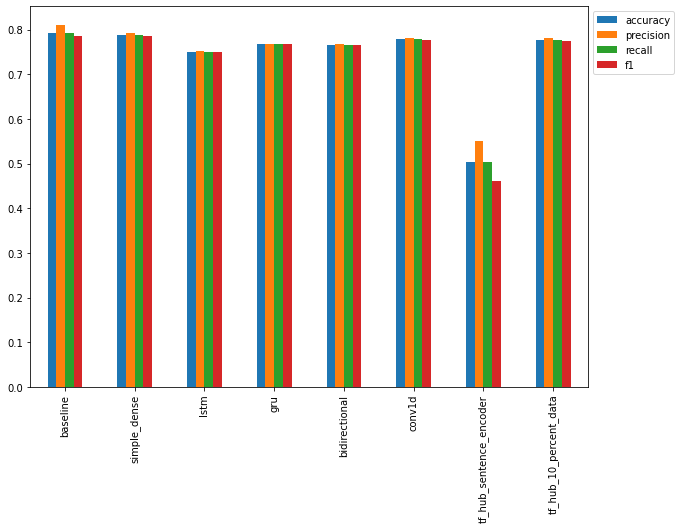

In [107]:

# Plot and compare all of the model results
all_model_results.plot(kind="bar", figsize=(10, 7)).legend(bbox_to_anchor=(1.0, 1.0));

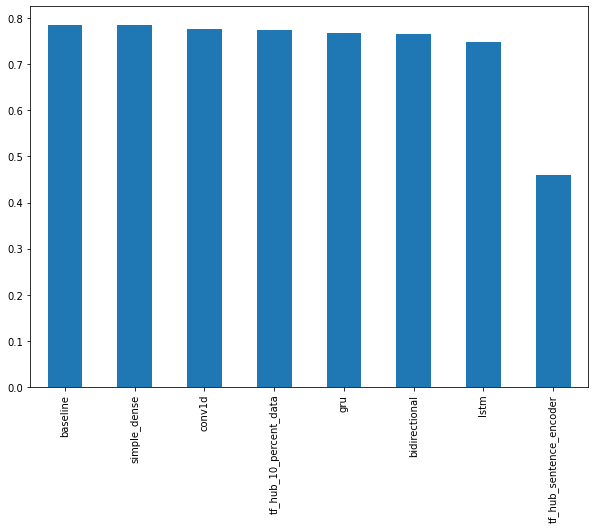

In [108]:
# Sort model results by f1-score
all_model_results.sort_values("f1", ascending=False)["f1"].plot(kind="bar", figsize=(10, 7));

## Combining our models (model ensembling/stacking)

Many production systems use an ensemble (multiple different models combined) of models to make a prediction.

The idea behind model stacking is that if several uncorrelated models agree on a prediction, then the prediction must be more robust than a prediction made by a singular model.

The keyword in the sentence above is uncorrelated, which is another way of saying, different types of models. For example, in our case, we might combine our baseline, our bidirectional model and our TensorFlow Hub USE model.

Although these models are all trained on the same data, they all have a different way of finding patterns.

If we were to use three similarly trained models, such as three LSTM models, the predictions they output will likely be very similar.

Think of it as trying to decide where to eat with your friends. If you all have similar tastes, you'll probably all pick the same restaurant. But if you've all got different tastes and still end up picking the same restaurant, the restaurant must be good.

Since we're working with a classification problem, there are a few of ways we can combine our models:

**1. Averaging** - Take the output prediction probabilities of each model for each sample, combine them and then average them.

**2. Majority vote (mode)** - Make class predictions with each of your models on all samples, the predicted class is the one in majority. For example, if three different models predict [1, 0, 1] respectively, the majority class is 1, therefore, that would be the predicted label.

**3. Model stacking** - Take the outputs of each of your chosen models and use them as inputs to another model.

In [117]:
# Get mean pred probs for 3 models
baseline_pred_probs = np.max(model_0.predict_proba(val_sentences), axis=1) # get the prediction probabilities from baseline model
combined_pred_probs = baseline_pred_probs + tf.squeeze(model_2_pred_probs, axis=1) + tf.squeeze(model_1_pred_probs)
combined_preds = tf.round(combined_pred_probs/3) # average and round the prediction probabilities to get prediction classes
combined_preds[:20]

<tf.Tensor: shape=(20,), dtype=float32, numpy=
array([0., 1., 1., 0., 0., 1., 1., 1., 1., 1., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 1.], dtype=float32)>

Wonderful! We've got a combined predictions array of different classes, let's evaluate them against the true labels and add our stacked model's results to our all_model_results DataFrame.

In [118]:
# Calculate results from averaging the prediction probabilities
ensemble_results = calculate_results(val_labels, combined_preds)
ensemble_results

{'accuracy': 74.93438320209974,
 'f1': 0.7484479483637092,
 'precision': 0.7489330230482325,
 'recall': 0.7493438320209974}

In [119]:
# Add our combined model's results to the results DataFrame
all_model_results.loc["ensemble_results"] = ensemble_results

In [120]:
# Convert the accuracy to the same scale as the rest of the results
all_model_results.loc["ensemble_results"]["accuracy"] = all_model_results.loc["ensemble_results"]["accuracy"]/100

In [121]:

all_model_results

,accuracy,precision,recall,f1
baseline,0.792651,0.811139,0.792651,0.786219
simple_dense,0.787402,0.791492,0.787402,0.784697
lstm,0.750656,0.751008,0.750656,0.748927
gru,0.767717,0.767545,0.767717,0.766793
bidirectional,0.766404,0.766590,0.766404,0.765121
conv1d,0.778215,0.780752,0.778215,0.775881
tf_hub_sentence_encoder,0.503937,0.549743,0.503937,0.460497
tf_hub_10_percent_data,0.776903,0.780969,0.776903,0.773917
ensemble_results,0.749344,0.748933,0.749344,0.748448


## Finding the most wrong examples

e mentioned before that if many of our modelling experiments are returning similar results, despite using different kinds of models, it's a good idea to return to the data and inspect why this might be.

One of the best ways to inspect your data is to sort your model's predictions and find the samples it got most wrong, meaning, what predictions had a high prediction probability but turned out to be wrong.

Once again, visualization is your friend. Visualize, visualize, visualize.

To make things visual, let's take our best performing model's prediction probabilities and classes along with the validation samples (text and ground truth labels) and combine them in a pandas DataFrame.

* If our best model still isn't perfect, what examples is it getting wrong?
* Which ones are the most wrong?
* Are there some labels which are wrong? E.g. the model gets it right but the ground truth label doesn't reflect this

In [123]:
# Create dataframe with validation sentences and best performing model predictions
val_df = pd.DataFrame({"text": val_sentences,
                       "target": val_labels,
                       "pred": model_6_preds,
                       "pred_prob": tf.squeeze(model_6_pred_probs)})
val_df.head()

,text,target,pred,pred_prob
0,DFR EP016 Monthly Meltdown - On Dnbheaven 2015...,0,1.0,0.502315
1,FedEx no longer to transport bioterror germs i...,0,1.0,0.513166
2,Gunmen kill four in El Salvador bus attack: Su...,1,1.0,0.520635
3,@camilacabello97 Internally and externally scr...,1,1.0,0.519447
4,Radiation emergency #preparedness starts with ...,1,1.0,0.509819


In [125]:
 #Find the wrong predictions and sort by prediction probabilities
most_wrong = val_df[val_df["target"] != val_df["pred"]].sort_values("pred_prob", ascending=False)
most_wrong[:10]

,text,target,pred,pred_prob
716,Crackdown 3 Destruction Restricted to Multipla...,0,1.0,0.547264
729,Crackdown 3 Destruction Restricted to Multipla...,0,1.0,0.545132
520,Wrinkled the face of deluge as decayed;,0,1.0,0.544498
568,Untangle yourself from requiring your partner ...,0,1.0,0.543779
682,A change in the State fire code prohibits gril...,0,1.0,0.541711
33,#ArrestpastorNganga it so worrying 2 see how s...,0,1.0,0.539081
546,Enugu Government to demolish illegal structure...,0,1.0,0.538071
654,Armageddon averted by El Patron\n#UltimaLucha,0,1.0,0.537201
574,Your PSA for the day: If a fire truck is behin...,0,1.0,0.536670
37,@almusafirah_ you feel trapped innit ??,0,1.0,0.536466


Finally, we can write some code to visualize the sample text, truth label, prediction class and prediction probability. Because we've sorted our samples by prediction probability, viewing samples from the head of our most_wrong DataFrame will show us false positives.

In [127]:
# Check the false positives (model predicted 1 when should've been 0)
for row in most_wrong[:10].itertuples(): # loop through the top 10 rows (change the index to view different rows)
  _, text, target, pred, prob = row
  print(f"Target: {target}, Pred: {int(pred)}, Prob: {prob}")
  print(f"Text:\n{text}\n")
  print("----\n")

Target: 0, Pred: 1, Prob: 0.5472635626792908
Text:
Crackdown 3 Destruction Restricted to Multiplayer: Crackdown 3 impressed earlier this week with a demonstratio... http://t.co/gwESgesZxV

----

Target: 0, Pred: 1, Prob: 0.5451317429542542
Text:
Crackdown 3 Destruction Restricted to Multiplayer: Crackdown 3 impressed earlier this week with a demonstratio... http://t.co/LMWKjsYCgj

----

Target: 0, Pred: 1, Prob: 0.5444976091384888
Text:
Wrinkled the face of deluge as decayed;

----

Target: 0, Pred: 1, Prob: 0.5437787771224976
Text:
Untangle yourself from requiring your partner to fill your needs and how to love without fear #BestTalkRadio Listen http://t.co/8j09ZUTxWT

----

Target: 0, Pred: 1, Prob: 0.5417109131813049
Text:
A change in the State fire code prohibits grills on decks at condos and apartment buildings.  Check with your... http://t.co/KE1ZS6NAml

----

Target: 0, Pred: 1, Prob: 0.539081335067749
Text:
#ArrestpastorNganga it so worrying 2 see how some police officers in Ke

In [128]:

# Check the most wrong false negatives (model predicted 0 when should've predict 1)
for row in most_wrong[-10:].itertuples():
  _, text, target, pred, prob = row
  print(f"Target: {target}, Pred: {int(pred)}, Prob: {prob}")
  print(f"Text:\n{text}\n")
  print("----\n")

Target: 1, Pred: 0, Prob: 0.4887546896934509
Text:
First time getting into #gbbo2015 and physically gasped at the cake 'mudslide' incident already way too emotionally invested...

----

Target: 1, Pred: 0, Prob: 0.48840588331222534
Text:
@KlaraJoelsson Well I have seen it now! That's a bummer. We've had this heat wave tho... 43'c!! I'd prefer the rain... :P

----

Target: 1, Pred: 0, Prob: 0.4868015944957733
Text:
Leitchfield KY:

 Bella Edward &amp; Rosalie need rescue/adoption/local foster home(s)/sponsorships.

 Trapped &amp;... http://t.co/Ajay0sNPlg

----

Target: 1, Pred: 0, Prob: 0.4865732192993164
Text:
Sadly before she could save humanity Ursula drowned in the drool of a protoshoggoth but at least she sort of died doing what she loved.

----

Target: 1, Pred: 0, Prob: 0.4843946099281311
Text:
A Dayton-area org tells me it was hit by a cyber attack: http://t.co/7LhKJz0IVO

----

Target: 1, Pred: 0, Prob: 0.48165249824523926
Text:
MEG issues Hazardous Weather Outlook (HWO) http:

## Making predictions on the test dataset

In [129]:

# Making predictions on the test dataset
test_sentences = test_df["text"].to_list()
test_samples = random.sample(test_sentences, 10)
for test_sample in test_samples:
  pred_prob = tf.squeeze(model_6.predict([test_sample])) # has to be list
  pred = tf.round(pred_prob)
  print(f"Pred: {int(pred)}, Prob: {pred_prob}")
  print(f"Text:\n{test_sample}\n")
  print("----\n")

Pred: 1, Prob: 0.5115919709205627
Text:
??Water fight??
Penn park 6pm 
      BYOW
(Bring Your Own Weapons)

----

Pred: 0, Prob: 0.49229469895362854
Text:
Audio: Listen/purchase: Detonate (feat. M.O.P.) by Apollo Brown http://t.co/6ZSWtoKsif

----

Pred: 1, Prob: 0.504982590675354
Text:
@dmon2112 @C_T_Morgan but the fire rings of NYC permits I'd have to jump through for a food truck don't make it appealing

----

Pred: 1, Prob: 0.5138631463050842
Text:
Love wounds

----

Pred: 1, Prob: 0.5242616534233093
Text:
@MattBuek Some pitchers gracefully lose their stuff. Some fall off a cliff and land on their throwing arm. Hard to tell who gets what.

----

Pred: 0, Prob: 0.49293631315231323
Text:
The revival of Cyclone Football begins today!!  Be there September 5th!!

----

Pred: 1, Prob: 0.5040991306304932
Text:
@HusnaaVhora I hope they dust off the air raid sirens! You can quote me on that lol

----

Pred: 1, Prob: 0.5163061618804932
Text:
Pak army helicopter crashed in Mansehra. 
Pray for


##Predicting on Tweets from the wild

In [131]:

# Turn Tweet into string
daniels_tweet = "Life like an ensemble: take the best choices from others and make your own"

In [132]:
def predict_on_sentence(model, sentence):
  """
  Uses model to make a prediction on sentence.

  Returns the sentence, the predicted label and the prediction probability.
  """
  pred_prob = model.predict([sentence])
  pred_label = tf.squeeze(tf.round(pred_prob)).numpy()
  print(f"Pred: {pred_label}", "(real disaster)" if pred_label > 0 else "(not real disaster)", f"Prob: {pred_prob[0][0]}")
  print(f"Text:\n{sentence}")

In [134]:
# Make a prediction on Tweet from the wild
predict_on_sentence(model=model_6, # use the USE model
                    sentence=daniels_tweet)

Pred: 1.0 (real disaster) Prob: 0.5110728740692139
Text:
Life like an ensemble: take the best choices from others and make your own


Woohoo! Our model predicted correctly. My Tweet wasn't about a diaster.

How about we find a few Tweets about actual diasters?

Such as the following two Tweets about the 2020 Beirut explosions.

In [135]:
# Source - https://twitter.com/BeirutCityGuide/status/1290696551376007168
beirut_tweet_1 = "Reports that the smoke in Beirut sky contains nitric acid, which is toxic. Please share and refrain from stepping outside unless urgent. #Lebanon"

# Source - https://twitter.com/BeirutCityGuide/status/1290773498743476224
beirut_tweet_2 = "#Beirut declared a “devastated city”, two-week state of emergency officially declared. #Lebanon"

In [137]:

# Predict on diaster Tweet 1
predict_on_sentence(model=model_6, 
                    sentence=beirut_tweet_1)

Pred: 1.0 (real disaster) Prob: 0.5291858315467834
Text:
Reports that the smoke in Beirut sky contains nitric acid, which is toxic. Please share and refrain from stepping outside unless urgent. #Lebanon


In [138]:

# Predict on diaster Tweet 2
predict_on_sentence(model=model_6, 
                    sentence=beirut_tweet_2)

Pred: 1.0 (real disaster) Prob: 0.5065233707427979
Text:
#Beirut declared a “devastated city”, two-week state of emergency officially declared. #Lebanon


Looks like our model is performing as expected, predicting both of the diaster Tweets as actual diasters.

🔑 Note: The above examples are cherry-picked and are cases where you'd expect a model to function at high performance. For actual production systems, you'll want to continaully perform tests to see how your model is performing.

## The speed/score tradeoff

One of the final tests we're going to do is to find the speed/score tradeoffs between our best model and baseline model.

Why is this important?

Although it can be tempting to just choose the best performing model you find through experimentation, this model might not actually work in a production setting.

Put it this way, imagine you're Twitter and receive 1 million Tweets per hour (this is a made up number, the actual number is much higher). And you're trying to build a diaster detection system to read Tweets and alert authorities with details about a diaster in close to real-time.

Compute power isn't free so you're limited to a single compute machine for the project. On that machine, one of your models makes 10,000 predictions per second at 80% accuracy where as another one of your models (a larger model) makes 100 predictions per second at 85% accuracy.

Which model do you choose?

Is the second model's performance boost worth missing out on the extra capacity?

Of course, there are many options you could try here, such as sending as many Tweets as possible to the first model and then sending the ones which the model is least certain of to the second model.

The point here is to illustrate the best model you find through experimentation, might not be the model you end up using in production.

To make this more concrete, let's write a function to take a model and a number of samples and time how long the given model takes to make predictions on those samples.



In [141]:
# Calculate the time of predictions
import time
def pred_timer(model, samples):
  """
  Times how long a model takes to make predictions on samples.
  
  Args:
  ----
  model = a trained model
  sample = a list of samples

  Returns:
  ----
  total_time = total elapsed time for model to make predictions on samples
  time_per_pred = time in seconds per single sample
  """
  start_time = time.perf_counter() # get start time
  model.predict(samples) # make predictions
  end_time = time.perf_counter() # get finish time
  total_time = end_time-start_time # calculate how long predictions took to make
  time_per_pred = total_time/len(val_sentences) # find prediction time per sample
  return total_time, time_per_pred

In [142]:
# Calculate TF Hub Sentence Encoder prediction times
model_6_total_pred_time, model_6_time_per_pred = pred_timer(model_6, val_sentences)
model_6_total_pred_time, model_6_time_per_pred

(0.4095418160004556, 0.0005374564514441674)

In [143]:
# Calculate Naive Bayes prediction times
baseline_total_pred_time, baseline_time_per_pred = pred_timer(model_0, val_sentences)
baseline_total_pred_time, baseline_time_per_pred

(0.027831357000650314, 3.652409055203453e-05)

It seems with our current hardware (in my case, I'm using a Google Colab notebook) our best performing model takes over 10x the time to make predictions as our baseline model.

Is that extra prediction time worth it?

Let's compare time per prediction versus our model's F1-scores.

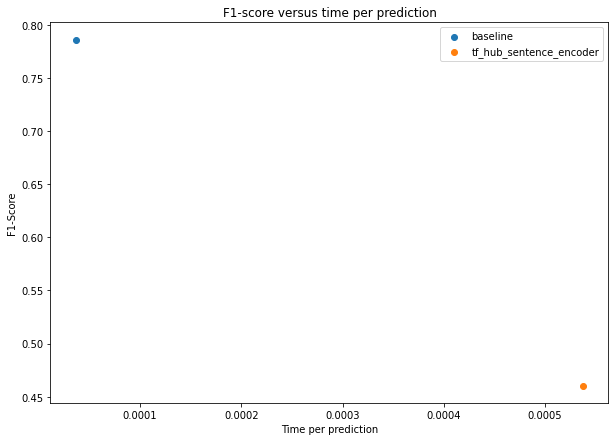

In [145]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 7))
plt.scatter(baseline_time_per_pred, baseline_results["f1"], label="baseline")
plt.scatter(model_6_time_per_pred, model_6_results["f1"], label="tf_hub_sentence_encoder")
plt.legend()
plt.title("F1-score versus time per prediction")
plt.xlabel("Time per prediction")
plt.ylabel("F1-Score");

Of course, the ideal position for each of these dots is to be in the top left of the plot (low time per prediction, high F1-score).

In our case, there's a clear tradeoff for time per prediction and performance. Our best performing model takes an order of magnitude longer per prediction but only results in a few F1-score point increase.

This kind of tradeoff is something you'll need to keep in mind when incorporating machine learning models into your own applications.